In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification, pipeline

from sklearn import set_config
set_config(transform_output = "pandas")

In [4]:
df = pd.read_csv("data/churn_dataset.csv")
df = df.dropna().reset_index(drop=True)

### Sentiment Analysis

In [3]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [4]:
top_k = 1

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
model = RobertaForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
sentiment_classifier = pipeline(
    task="sentiment-analysis",
    tokenizer=tokenizer,
    model=model,
    top_k=top_k,
)

In [8]:
def sentiment(rows):
    resp = sentiment_classifier(rows["chat_log"])
    return {
        "sentiment_label": [i[0]["label"] for i in resp],
        "sentiment_score": [i[0]["score"] for i in resp]
    }

In [9]:
ddf = Dataset.from_pandas(df)

In [10]:
dddf = ddf.map(sentiment, batched=True, batch_size=50)

Map:   0%|          | 0/2636 [00:00<?, ? examples/s]

In [11]:
dddf.to_pandas().to_csv("churn_dataset_w_sentiment.csv", index=False)

### Pre-Processing

In [193]:
df = pd.read_csv("churn_dataset_w_sentiment.csv")

y = df.pop("churn")
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

preprocessor = make_pipeline(
    make_column_transformer(
        # (OneHotEncoder(sparse_output=False), ["state"]),
        (OrdinalEncoder(), ["international_plan", "voice_mail_plan"]),
        (OrdinalEncoder(categories=[["negative", "neutral", "positive"]]), ["sentiment_label"]),
        ("drop", ["area_code", "chat_log", "state",]),
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
)

preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

### Training

In [180]:
model = RandomForestClassifier()

In [181]:
model.fit(X_train, y_train)

RandomForestClassifier()

### Evaluation

In [326]:
y_pred = model.predict(X_test)

In [328]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       737
           1       0.90      0.78      0.84       133

    accuracy                           0.95       870
   macro avg       0.93      0.88      0.90       870
weighted avg       0.95      0.95      0.95       870



### Feature Importance

In [223]:
imp = pd.DataFrame(zip(model.feature_names_in_, model.feature_importances_))
imp.columns = ["name", "importance"]
imp.sort_values(by="importance", ascending=False)

,name,importance
2,sentiment_label,0.317258
5,total_day_minutes,0.106203
7,total_day_charge,0.104224
17,number_customer_service_calls,0.067868
18,sentiment_score,0.051843
8,total_eve_minutes,0.039424
10,total_eve_charge,0.038842
0,international_plan,0.031581
16,total_intl_charge,0.027956
15,total_intl_calls,0.026412


### EDA

In [233]:
df[(df["sentiment_score"] > 0.75) & (df["sentiment_label"] == "negative")]["churn"].value_counts()

churn
yes    114
no       4
Name: count, dtype: int64

In [243]:
pivot_table = df.groupby(['sentiment_label', pd.cut(df['sentiment_score'], bins=[0.38, 0.5, 0.8, 1], labels=['Weak', 'Moderate', 'Strong'])])['churn'].value_counts().unstack()


<ipython-input-243-5a3af18e1b07>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = df.groupby(['sentiment_label', pd.cut(df['sentiment_score'], bins=[0.38, 0.5, 0.8, 1], labels=['Weak', 'Moderate', 'Strong'])])['churn'].value_counts().unstack()


In [244]:
pivot_table

churn                             no  yes
sentiment_label sentiment_score          
negative        Weak               9   10
                Moderate          64  202
                Strong             1   77
neutral         Weak              29   11
                Moderate         952   72
                Strong           340    5
positive        Weak              15    3
                Moderate         540    8
                Strong           295    3

In [230]:
df.churn.value_counts()

churn
no     2245
yes     391
Name: count, dtype: int64

In [202]:
df[(df["sentiment_score"] < 0.8) & (df["sentiment_label"] == "negative")].churn.value_counts()

churn
yes    212
no      73
Name: count, dtype: int64

<AxesSubplot:>

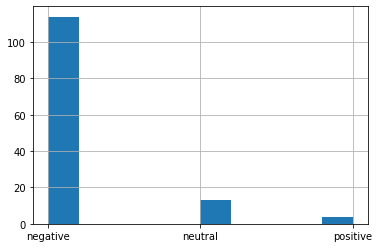

In [216]:
df[(df["churn"]=="yes")&(df["sentiment_score"] > 0.75)]["sentiment_label"].hist()

<AxesSubplot:>

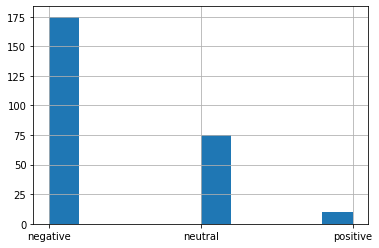

In [220]:
df[(df["churn"]=="yes")&(df["sentiment_score"] < 0.75)]["sentiment_label"].hist()

<AxesSubplot:>

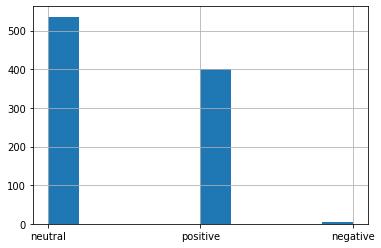

In [219]:
df[(df["churn"]=="no")&(df["sentiment_score"] > 0.75)]["sentiment_label"].hist()

In [316]:
y_pred = model.predict_proba(X_test)

In [317]:
probas = pd.DataFrame(y_pred.tolist(), columns=["no_churn_likelihood", "churn_likelihood"])

In [318]:
churn_actual = pd.DataFrame(y_test, columns=["churn"])

In [319]:
probas.index = X_test.index
churn_actual.index = X_test.index

In [320]:
ddff = pd.concat([X_test, churn_actual, probas], axis=1)

In [321]:
import matplotlib.pyplot as plt

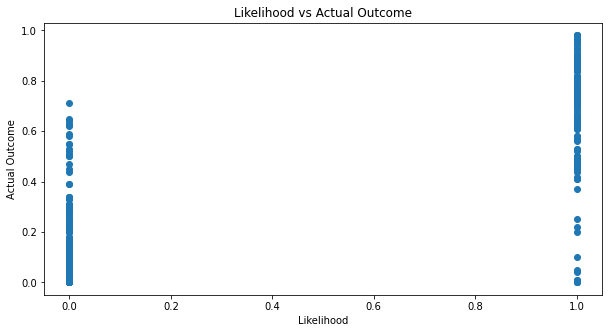

In [322]:
plt.figure(figsize=(10,5))
plt.scatter(ddff['churn'], ddff['churn_likelihood'])
# for i, row in ddff.iterrows():
#     plt.annotate(f'Likelihood: {row["churn_likelihood"]:.2f}', (row['churn_likelihood'], row['churn']), textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel('Likelihood')
plt.ylabel('Actual Outcome')
plt.title('Likelihood vs Actual Outcome')
plt.show()

In [323]:
from scipy.stats import gaussian_kde
import numpy as np

In [324]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

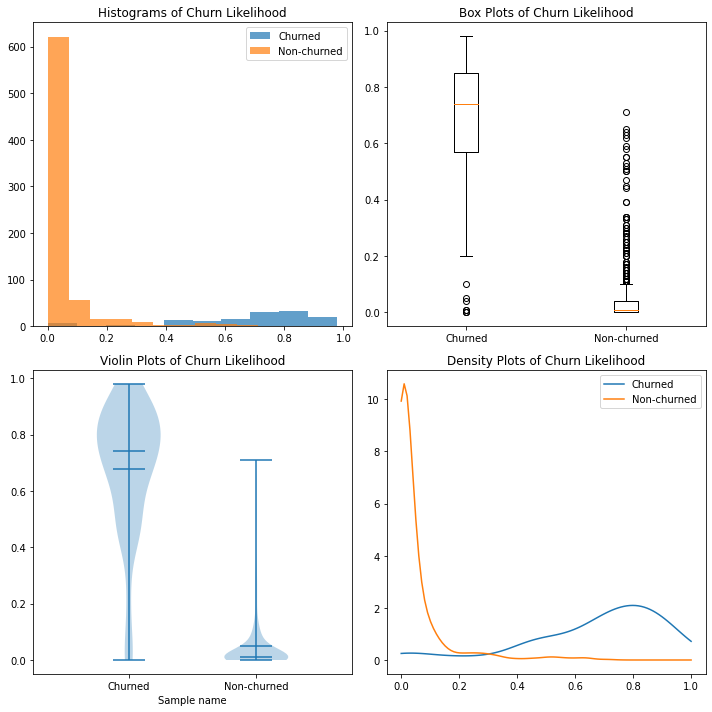

In [325]:
import matplotlib.pyplot as plt

# Assuming df contains your data with 'y_actual' and 'y_likelihood' columns

plt.figure(figsize=(10, 10))

# Histograms
plt.subplot(2, 2, 1)
plt.hist(ddff[ddff['churn'] == 1]['churn_likelihood'], alpha=0.7, label='Churned')
plt.hist(ddff[ddff['churn'] == 0]['churn_likelihood'], alpha=0.7, label='Non-churned')
plt.legend()
plt.title('Histograms of Churn Likelihood')

# Box Plots
plt.subplot(2, 2, 2)
plt.boxplot([ddff[ddff['churn'] == 1]['churn_likelihood'], ddff[ddff['churn'] == 0]['churn_likelihood']], labels=['Churned', 'Non-churned'])
plt.title('Box Plots of Churn Likelihood')

# Violin Plot
ax = plt.subplot(2, 2, 3)
plt.violinplot([ddff[ddff['churn'] == 1]['churn_likelihood'], ddff[ddff['churn'] == 0]['churn_likelihood']], showmeans=True, showextrema=True, showmedians=True)
set_axis_style(ax, labels=["Churned", "Non-churned"])
plt.title('Violin Plots of Churn Likelihood')

# Density Plot
from scipy.stats import gaussian_kde

kde_churned = gaussian_kde(ddff[ddff['churn'] == 1]['churn_likelihood'])
kde_nonchurned = gaussian_kde(ddff[ddff['churn'] == 0]['churn_likelihood'])

x_grid = np.linspace(0, 1, 100)

plt.subplot(2, 2, 4)
plt.plot(x_grid, kde_churned(x_grid), label='Churned')
plt.plot(x_grid, kde_nonchurned(x_grid), label='Non-churned')
plt.legend()
plt.title('Density Plots of Churn Likelihood')

plt.tight_layout()
plt.show()